# LSTM Model for Time Series Forecasting

This notebook demonstrates the LSTM (Long Short-Term Memory) neural network model for stock price forecasting.

**Contents:**
1. **Data Preparation** - Scaling and sequence creation
2. **Model Architecture** - Building the LSTM network
3. **Model Training** - Training with early stopping
4. **Evaluation** - Performance metrics (MAE, RMSE, MAPE)
5. **Forecasting** - Future predictions with uncertainty estimates
6. **Training Analysis** - Loss curves and diagnostics

LSTM is a type of recurrent neural network (RNN) that can learn long-term dependencies in sequential data:
- **Forget Gate**: Decides what information to discard from cell state
- **Input Gate**: Decides which new information to store in cell state
- **Output Gate**: Decides what to output based on cell state

## Setup

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Add project root to path
sys.path.insert(0, os.path.dirname(os.getcwd()))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Project modules
import config
from src.data_cleaning import cleaned_data_loader
from src.models.baseline import train_test_split
from src.models.lstm_model import (
    LSTMModel,
    create_sequences,
    prepare_lstm_data,
    evaluate_lstm,
    forecast_future_lstm,
    run_lstm_analysis
)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

print("Configuration:")
print(f"  Train/Test Split: {config.TRAIN_TEST_SPLIT}")
print(f"  Prediction Horizon: {config.PREDICTION_HORIZON_DAYS} days")
print(f"  Sequence Length: {config.LSTM_SEQUENCE_LENGTH}")
print(f"  LSTM Units: {config.LSTM_UNITS}")
print(f"  Dropout Rate: {config.LSTM_DROPOUT}")
print(f"  Epochs: {config.LSTM_EPOCHS}")
print(f"  Batch Size: {config.LSTM_BATCH_SIZE}")

Importing plotly failed. Interactive plots will not work.


Configuration:
  Train/Test Split: 0.8
  Prediction Horizon: 20 days
  Sequence Length: 60
  LSTM Units: [50, 50]
  Dropout Rate: 0.2
  Epochs: 50
  Batch Size: 32


## Load Data

In [2]:
# Load cleaned stock data
try:
    data = cleaned_data_loader()
except FileNotFoundError:
    from src.data_collection import download_stock_data
    from src.data_cleaning import cleaned_data
    
    print("No cleaned data found. Downloading and cleaning...")
    raw_data = download_stock_data()
    data = cleaned_data(raw_data)

print(f"\nData shape: {data.shape}")
print(f"Date range: {data.index.min()} to {data.index.max()}")
data.tail()

Loading cleaned data from: data/processed\cleaned_data_20260120_010244.csv
Loaded 1519 data points
Date range: 2020-01-02 00:00:00 to 2026-01-16 00:00:00
Columns: Open, High, Low, Close, Volume

Data shape: (1519, 5)
Date range: 2020-01-02 00:00:00 to 2026-01-16 00:00:00


,Open,High,Low,Close,Volume
Date,,,,,
2026-01-12,259.160004,261.299988,256.799988,260.250000,45263800
2026-01-13,258.720001,261.809998,258.390015,261.049988,45730800
2026-01-14,259.489990,261.820007,256.709991,259.959991,40019400
2026-01-15,260.649994,261.040009,257.049988,258.209991,39388600
2026-01-16,257.899994,258.899994,254.929993,255.529999,72018600


## Train/Test Split

For time series, we use a time-based split (no shuffling) to prevent data leakage.

Train/Test Split:
  Train: 1215 samples (2020-01-02 to 2024-10-29)
  Test: 304 samples (2024-10-30 to 2026-01-16)


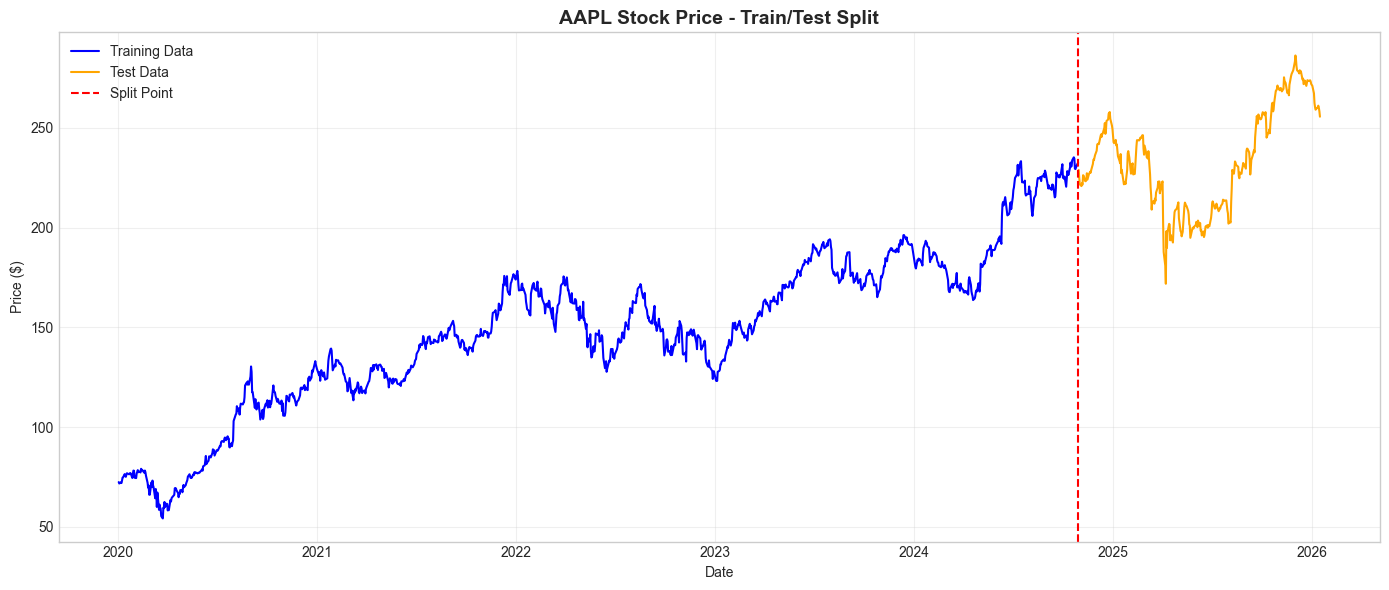

In [3]:
# Split data
train, test = train_test_split(data)

# Visualize split
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(train.index, train['Close'], label='Training Data', color='blue')
ax.plot(test.index, test['Close'], label='Test Data', color='orange')
ax.axvline(x=train.index[-1], color='red', linestyle='--', label='Split Point')

ax.set_title(f'{config.DEFAULT_TICKER} Stock Price - Train/Test Split', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Data Preparation for LSTM

LSTM requires:
1. **Scaling**: Neural networks work better with normalized data
2. **Sequences**: Convert time series to supervised learning format (X: lookback window, y: next value)

In [4]:
# Prepare data for LSTM
sequence_length = config.LSTM_SEQUENCE_LENGTH

data_prep = prepare_lstm_data(
    train_data=train,
    test_data=test,
    column='Close',
    sequence_length=sequence_length,
    scaler_type='minmax'
)

print(f"Sequence Length: {sequence_length} days")
print(f"\nTraining Data:")
print(f"  X_train shape: {data_prep['X_train'].shape} (samples, timesteps, features)")
print(f"  y_train shape: {data_prep['y_train'].shape}")
print(f"\nTest Data:")
print(f"  X_test shape: {data_prep['X_test'].shape}")
print(f"  y_test shape: {data_prep['y_test'].shape}")

Sequence Length: 60 days

Training Data:
  X_train shape: (1155, 60, 1) (samples, timesteps, features)
  y_train shape: (1155,)

Test Data:
  X_test shape: (304, 60, 1)
  y_test shape: (304,)


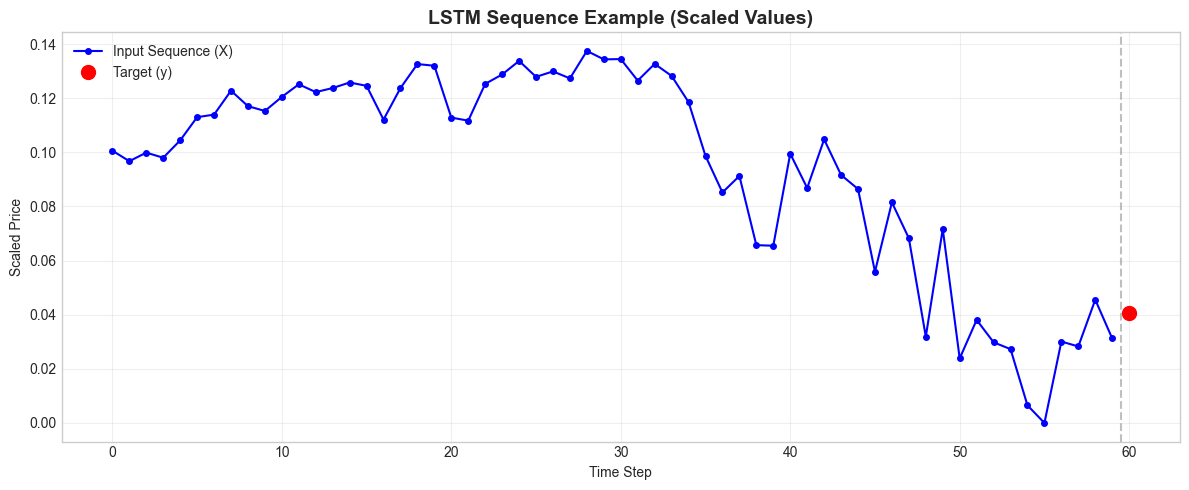

In [5]:
# Visualize a sample sequence
fig, ax = plt.subplots(figsize=(12, 5))

sample_idx = 0
sample_sequence = data_prep['X_train'][sample_idx, :, 0]
sample_target = data_prep['y_train'][sample_idx]

ax.plot(range(sequence_length), sample_sequence, 'b-o', label='Input Sequence (X)', markersize=4)
ax.plot(sequence_length, sample_target, 'ro', markersize=10, label='Target (y)')
ax.axvline(x=sequence_length - 0.5, color='gray', linestyle='--', alpha=0.5)

ax.set_title('LSTM Sequence Example (Scaled Values)', fontsize=14, fontweight='bold')
ax.set_xlabel('Time Step')
ax.set_ylabel('Scaled Price')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Build and Train LSTM Model

In [6]:
# Create LSTM model
model = LSTMModel(
    sequence_length=config.LSTM_SEQUENCE_LENGTH,
    lstm_units=config.LSTM_UNITS,
    dropout_rate=config.LSTM_DROPOUT,
    learning_rate=config.LSTM_LEARNING_RATE,
    epochs=config.LSTM_EPOCHS,
    batch_size=config.LSTM_BATCH_SIZE,
    early_stopping=True,
    patience=10
)

print(f"Model Configuration:")
for key, value in model.get_params().items():
    print(f"  {key}: {value}")

Model Configuration:
  sequence_length: 60
  lstm_units: [50, 50]
  dropout_rate: 0.2
  learning_rate: 0.001
  epochs: 50
  batch_size: 32
  scaler_type: minmax
  early_stopping: True
  patience: 10
  random_seed: 42


In [7]:
# Train the model
model.fit(train, column='Close', validation_split=0.1, verbose=1)


--- Fitting LSTM Model ---
Training samples: 1215
Date range: 2020-01-02 to 2024-10-29
Sequence length: 60
LSTM units: [50, 50]
Dropout rate: 0.2
Epochs: 50
Batch size: 32

Training sequences: 1155
Input shape: (1155, 60, 1)
Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0542 - mae: 0.1631 - val_loss: 0.0138 - val_mae: 0.1124 - learning_rate: 0.0010
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0055 - mae: 0.0601 - val_loss: 0.0102 - val_mae: 0.0952 - learning_rate: 0.0010
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0039 - mae: 0.0496 - val_loss: 0.0044 - val_mae: 0.0590 - learning_rate: 0.0010
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0039 - mae: 0.0485 - val_loss: 0.0030 - val_mae: 0.0463 - learning_rate: 0.0010
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0038 - mae: 0.0482 - val_loss: 0.0041 - val_mae: 0.0565 - learning_rate: 0.0010
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0032 - m

In [8]:
# Print model summary
print(model.summary())

Model: "sequential"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴─────────────────────

## Training History

Visualize the training and validation loss over epochs.

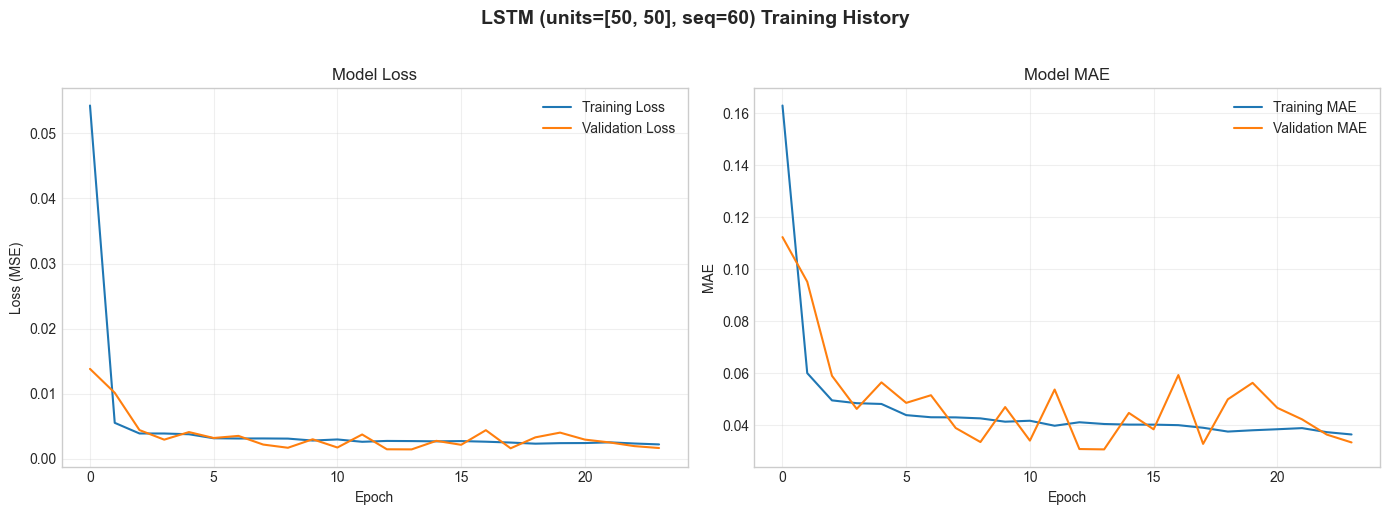

In [9]:
# Plot training history
fig = model.plot_training_history(figsize=(14, 5))
plt.suptitle(f'{model.name} Training History', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Model Evaluation

In [10]:
# Evaluate on test set
evaluation = evaluate_lstm(model, test, column='Close')

print(f"\n{'='*50}")
print("EVALUATION METRICS")
print(f"{'='*50}")
print(f"MAE:  ${evaluation['mae']:.2f}")
print(f"RMSE: ${evaluation['rmse']:.2f}")
print(f"MAPE: {evaluation['mape']:.2f}%")


LSTM (units=[50, 50], seq=60) Evaluation:
  MAE: $27.75
  RMSE: $36.49
  MAPE: 11.05%

EVALUATION METRICS
MAE:  $27.75
RMSE: $36.49
MAPE: 11.05%


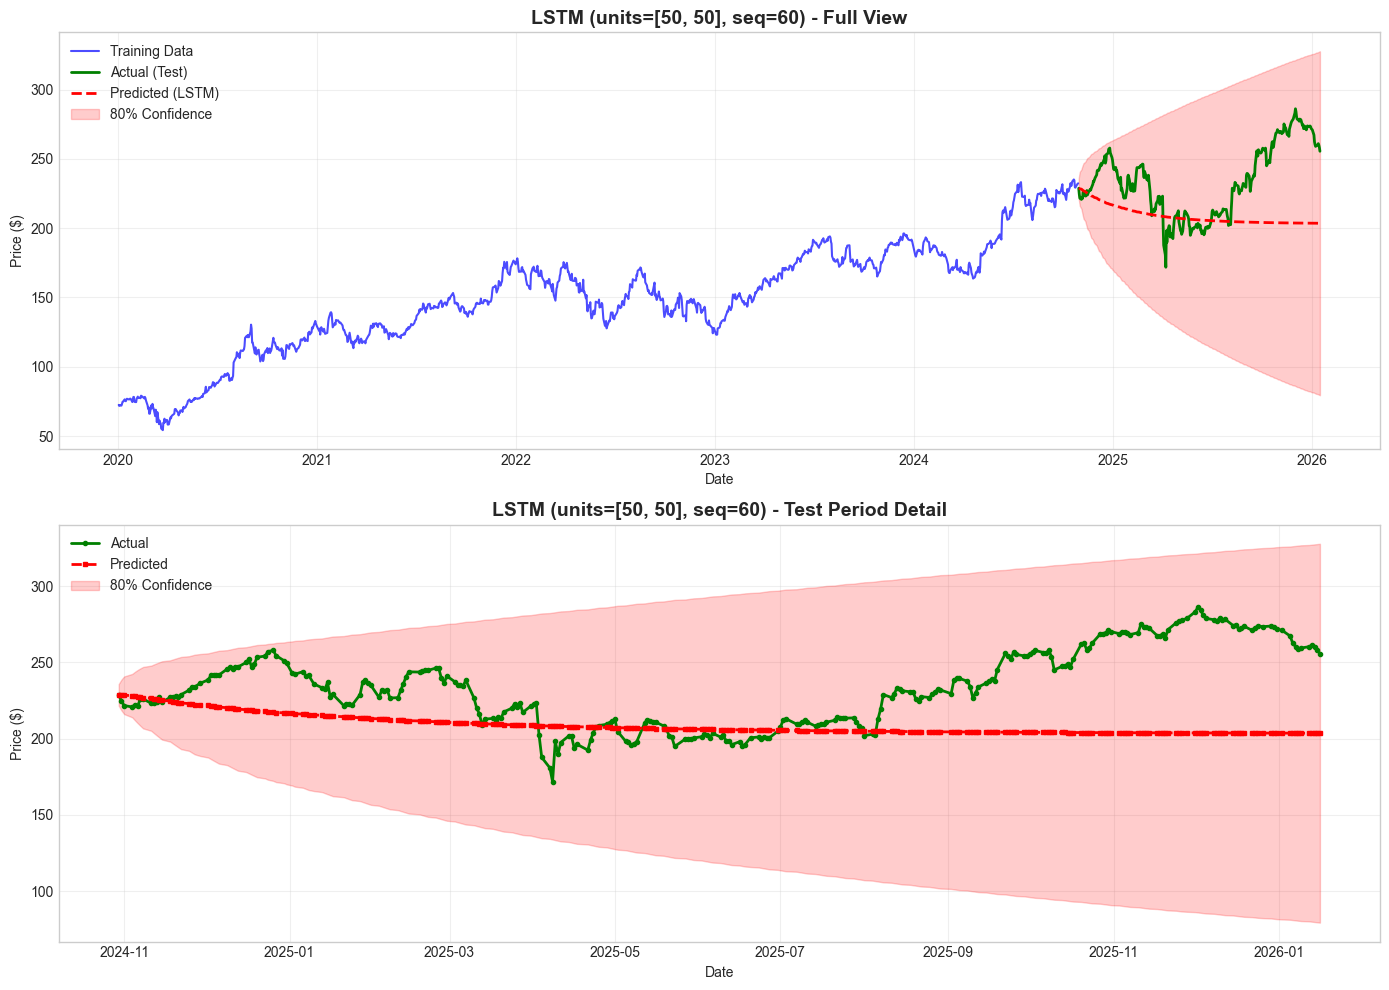

In [11]:
# Plot predictions vs actuals
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Full view
ax1 = axes[0]
ax1.plot(train.index, train['Close'], label='Training Data', color='blue', alpha=0.7)
ax1.plot(test.index, test['Close'], label='Actual (Test)', color='green', linewidth=2)
ax1.plot(test.index, evaluation['predictions'], label='Predicted (LSTM)', color='red', linestyle='--', linewidth=2)
ax1.fill_between(test.index, evaluation['lower_bound'], evaluation['upper_bound'], 
                  color='red', alpha=0.2, label='80% Confidence')

ax1.set_title(f'{model.name} - Full View', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price ($)')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Zoomed view (test period only)
ax2 = axes[1]
ax2.plot(test.index, test['Close'], label='Actual', color='green', linewidth=2, marker='o', markersize=3)
ax2.plot(test.index, evaluation['predictions'], label='Predicted', color='red', linestyle='--', linewidth=2, marker='s', markersize=3)
ax2.fill_between(test.index, evaluation['lower_bound'], evaluation['upper_bound'], 
                  color='red', alpha=0.2, label='80% Confidence')

ax2.set_title(f'{model.name} - Test Period Detail', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price ($)')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

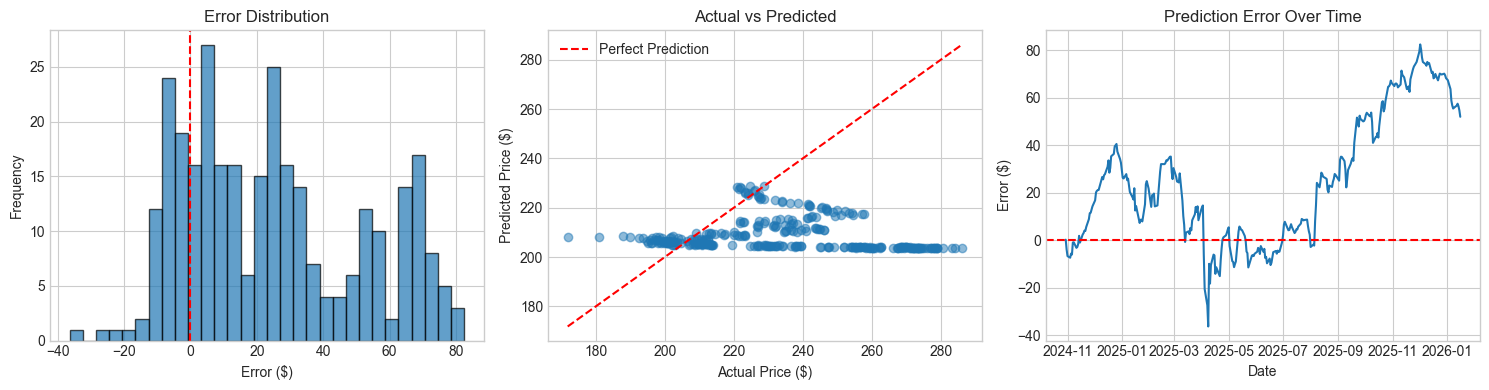


Error Statistics:
  Mean Error: $24.76
  Error Std Dev: $26.80
  Max Underestimate: $-36.41
  Max Overestimate: $82.45


In [12]:
# Error analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Error distribution
axes[0].hist(evaluation['errors'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--')
axes[0].set_title('Error Distribution')
axes[0].set_xlabel('Error ($)')
axes[0].set_ylabel('Frequency')

# Actual vs Predicted scatter
axes[1].scatter(evaluation['actuals'], evaluation['predictions'], alpha=0.5)
axes[1].plot([min(evaluation['actuals']), max(evaluation['actuals'])], 
             [min(evaluation['actuals']), max(evaluation['actuals'])], 'r--', label='Perfect Prediction')
axes[1].set_title('Actual vs Predicted')
axes[1].set_xlabel('Actual Price ($)')
axes[1].set_ylabel('Predicted Price ($)')
axes[1].legend()

# Error over time
axes[2].plot(test.index, evaluation['errors'])
axes[2].axhline(y=0, color='red', linestyle='--')
axes[2].set_title('Prediction Error Over Time')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Error ($)')

plt.tight_layout()
plt.show()

print(f"\nError Statistics:")
print(f"  Mean Error: ${np.mean(evaluation['errors']):.2f}")
print(f"  Error Std Dev: ${np.std(evaluation['errors']):.2f}")
print(f"  Max Underestimate: ${np.min(evaluation['errors']):.2f}")
print(f"  Max Overestimate: ${np.max(evaluation['errors']):.2f}")

## Future Forecast

Generate predictions for the next trading days.

In [13]:
# Generate future forecast
forecast = forecast_future_lstm(
    model,
    horizon=config.PREDICTION_HORIZON_DAYS,
    last_date=data.index[-1],
    confidence_level=0.8
)

print(f"\n{config.PREDICTION_HORIZON_DAYS}-Day Forecast:")
forecast


LSTM (units=[50, 50], seq=60) - 20-day Forecast:
Confidence Level: 80%
              forecast       lower       upper
2026-01-19  228.646622  221.527815  235.765428
2026-01-20  228.593781  218.526268  238.661293
2026-01-21  228.427170  216.097036  240.757304
2026-01-22  228.183624  213.946012  242.421237
2026-01-23  227.888580  211.970446  243.806715
2026-01-26  227.560410  210.122967  244.997853
2026-01-27  227.211868  208.377277  246.046459
2026-01-28  226.851913  206.716889  246.986938
2026-01-29  226.486710  205.130291  247.843129
2026-01-30  226.120193  203.608551  248.631836
... (10 more rows)

20-Day Forecast:


,forecast,lower,upper
2026-01-19,228.646622,221.527815,235.765428
2026-01-20,228.593781,218.526268,238.661293
2026-01-21,228.427170,216.097036,240.757304
2026-01-22,228.183624,213.946012,242.421237
2026-01-23,227.888580,211.970446,243.806715
2026-01-26,227.560410,210.122967,244.997853
2026-01-27,227.211868,208.377277,246.046459
2026-01-28,226.851913,206.716889,246.986938
2026-01-29,226.486710,205.130291,247.843129
2026-01-30,226.120193,203.608551,248.631836


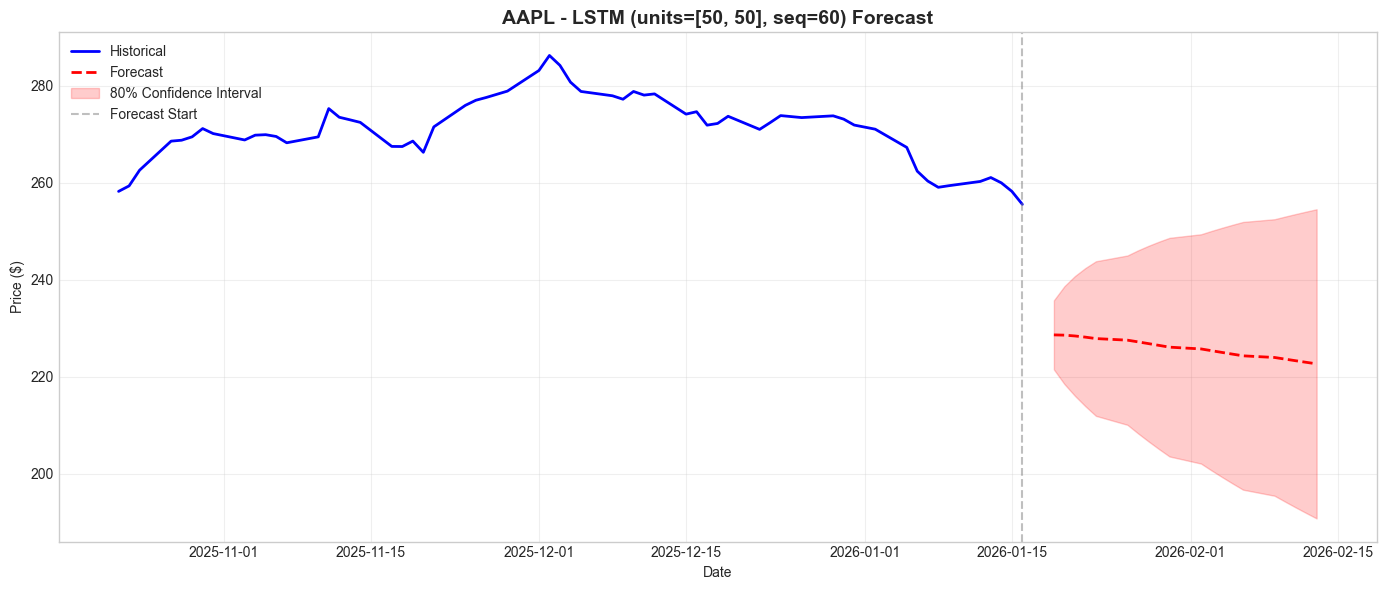


Forecast Summary:
  Current Price: $255.53
  Forecast Mean: $225.89
  Forecast End: $222.68
  Expected Change: -12.85%


In [14]:
# Plot future forecast
fig, ax = plt.subplots(figsize=(14, 6))

# Historical data (last 60 days)
history_days = 60
recent_data = data.iloc[-history_days:]

ax.plot(recent_data.index, recent_data['Close'], label='Historical', color='blue', linewidth=2)
ax.plot(forecast.index, forecast['forecast'], label='Forecast', color='red', linewidth=2, linestyle='--')
ax.fill_between(forecast.index, forecast['lower'], forecast['upper'], 
                color='red', alpha=0.2, label='80% Confidence Interval')

# Mark the transition point
ax.axvline(x=data.index[-1], color='gray', linestyle='--', alpha=0.5, label='Forecast Start')

ax.set_title(f'{config.DEFAULT_TICKER} - {model.name} Forecast', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nForecast Summary:")
print(f"  Current Price: ${data['Close'].iloc[-1]:.2f}")
print(f"  Forecast Mean: ${forecast['forecast'].mean():.2f}")
print(f"  Forecast End: ${forecast['forecast'].iloc[-1]:.2f}")
print(f"  Expected Change: {((forecast['forecast'].iloc[-1] / data['Close'].iloc[-1]) - 1) * 100:.2f}%")

## Run Complete Analysis Pipeline

You can also use the convenience function to run the entire LSTM analysis in one call.

In [15]:
# Run complete LSTM analysis
# Uncomment below to run the full pipeline

# results = run_lstm_analysis(
#     data,
#     column='Close',
#     tune_hyperparameters=False  # Set to True for hyperparameter tuning (slower)
# )

## Model Comparison Notes

When comparing LSTM with other models:

| Aspect | LSTM | ARIMA | Prophet |
|--------|------|-------|--------|
| **Complexity** | High | Medium | Low |
| **Training Time** | Long | Fast | Medium |
| **Non-linear Patterns** | Excellent | Poor | Good |
| **Interpretability** | Low | High | High |
| **Data Requirements** | More | Less | Less |
| **Seasonality** | Learned | Manual/Auto | Auto |

### LSTM Strengths:
- Can capture complex non-linear patterns
- Learns features automatically
- Can incorporate multiple features easily

### LSTM Limitations:
- Requires more data for training
- Computationally expensive
- Prone to overfitting
- Less interpretable ("black box")

In [16]:
print("\n" + "="*60)
print("LSTM MODEL NOTEBOOK COMPLETE")
print("="*60)
print(f"\nModel: {model.name}")
print(f"Test MAE: ${evaluation['mae']:.2f}")
print(f"Test RMSE: ${evaluation['rmse']:.2f}")
print(f"Test MAPE: {evaluation['mape']:.2f}%")


LSTM MODEL NOTEBOOK COMPLETE

Model: LSTM (units=[50, 50], seq=60)
Test MAE: $27.75
Test RMSE: $36.49
Test MAPE: 11.05%
